<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Setup

In [ ]:
#we need Torch 1.12 + and Torchvision 0.13 + for this study
try:
  import torch, torchvision
  assert int(torch.__version__.split(".")[1])>=12, "Torch version should be 1.12 or above"
  assert int(torchvision.__version__.split(".")[1])>=13, "Torch version should be 0.12 or above"
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")
except:
  print("Available libraries not updated, downloading updated libraries")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch, torchvision
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")

Available libraries not updated, downloading updated libraries
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 98.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using

Torch version:2.3.0+cu121
torchvision version:0.18.0+cu121


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

##Importing previously written scripts

In [ ]:
%%writefile data_setup.py
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

NUM_WORKERS= os.cpu_count()
def create_dataloaders(
    train_dir: str,
    test_dir:str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size:int,
    num_workers: int=NUM_WORKERS
):

  training_data=datasets.ImageFolder(root=train_dir, transform=train_transform)
  testing_data=datasets.ImageFolder(root=test_dir, transform=test_transform)
  class_names=training_data.classes
  train_dataloader=DataLoader(dataset=training_data,
                              batch_size=batch_size,#sample per dataloader
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory= True)
  test_dataloader=DataLoader(dataset=testing_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory= True)
  return train_dataloader, test_dataloader, class_names


Writing data_setup.py


In [ ]:
%%writefile engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
              device: torch.device) -> Tuple[float, float]:
  #putting in training mode
  model.train()
  #setup training loss and training accuracy
  train_loss,train_acc=0,0

  for batch,(x,y) in enumerate(dataloader):
    #send data to target device
    x,y=x.to(device),y.to(device)
    #forward pass
    y_pred=model(x)
    #calculate and accumulate losses
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric for all batches
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #getting average loss and accuracy for each batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
  #putting in eval mode
  model.eval()
  #setup test loss and test accuracy
  test_loss,test_acc=0,0
  #turn on inference context manager
  with torch.inference_mode():
    #loop through dataloader batches
    for batch,(x,y) in enumerate(dataloader):
      #send data to target device
      x,y=x.to(device),y.to(device)
      #forward pass
      test_pred_logits=model(x)
      #calculate and accumulate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      #calculate and accumulate accuracy
      test_pred_labels=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)#can probably also use len(test_pred), not sure both should work i think
  #getting average loss and accuracy for each batch
  test_acc/=len(dataloader)
  test_loss/=len(dataloader)
  return test_loss, test_acc

#defining functions and various required parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs: int,
        device: torch.device) -> Dict[str, list]:
  #create empty results dictionary
  results={"train_loss":[],
           "test_loss":[],
           "train_acc":[],
           "test_acc":[]}
  #looping through train_step() and test_step()
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss, test_acc=test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)
  #print whats happening
    print(
        f"Epoch:{epoch+1}|"
        f"Train Loss:{train_loss:.4f}|"
        f"Training Accuracy: {train_acc:.4f}|"
        f"Test Loss: {test_loss:.4f}|"
        f"Test Accuracy: {test_acc:.4f}"
    )
    #updating result dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
  return results


Writing engine.py


In [ ]:
%%writefile utils.py
import torch
from pathlib import Path
def save_model(model:torch.nn.Module,
               target_dir: str,
               model_name:str):
  #creating target directory
  target_dir_path=Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  #creating model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path/model_name

  #save the model state_dict
  print(f"Saving model to:{model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing utils.py


##Device Agnostic Code

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##Define function to set random seed

In [ ]:
#set seeds
def set_seeds(seed:int=69):
  "set seed whenver required before torch operations. Default seed = 69"
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

##Get Data

In [ ]:
import requests
import zipfile
from pathlib import Path
import os
def download_data(source:str,
                  destination:str,
                  remove_source:bool=True)->Path:
  #setup path to data folder
  data_path= Path("data/")
  image_path=data_path/destination
  #check if image folder exists or not, if not prepare it
  if image_path.is_dir():
    print(f"{image_path} directory exists")
  else:
    print(f"Didnt find {image_path}, creating...")
    image_path.mkdir(parents=True, exist_ok=True)
    #the datset that will be used is a formatted dataset being taken from a github file, in general, wont get such formatted data
    #download pizza, steak, sushi data in zip file
    target_file=Path(source).name
    with open(data_path/target_file,"wb") as f:
      request = requests.get(source)
      print("Downloading data...")
      f.write(request.content)
    #unzip data
    with zipfile.ZipFile(data_path/target_file,"r") as zip_ref:
      print("Unzipping food_stuff file...")
      zip_ref.extractall(image_path)
    if remove_source:
      os.remove(data_path/target_file)
  return image_path

In [ ]:
image_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip", destination='pizza_steak_sushi_20_percent')
image_path

Didnt find data/pizza_steak_sushi_20_percent, creating...
Unzipping food_stuff file...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
!ls data/pizza_steak_sushi_20_percent

test  train


In [ ]:
#creating paths to train and test directories
train_dir=image_path/"train"
test_dir=image_path/"test"

##Get EfficientNet B2 Model

In [ ]:
def create_effnet_b2(num_classes:int=3):
  #1
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights).to(device)

  #2. freeze all parameters in feature extraction layer
  for param in model.features.parameters():
    param.requires_grad=False
  #3. set random seed
  set_seeds()

  #4. changing classifier layer
  model.classifier= torch.nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                        nn.Linear(in_features=1408,
                                                  out_features=num_classes,
                                                  bias=True).to(device))
  #5. give name
  model.name='effnet_b2'
  print(f"Making EfficientNet_B2")

  return model,weights,transforms

In [ ]:
eff_net_b2,eff_net_weights,eff_net_transforms=create_effnet_b2(num_classes=3)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 127MB/s]


Making EfficientNet_B2


In [ ]:
from torchinfo import summary
summary(eff_net_b2,input_size=(32,3,224,224),col_names=['input_size','output_size','num_params','trainable'], row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

Make dataloaders

In [ ]:
import data_setup
train_dataloader_eff_net_b2, test_dataloader_eff_net_b2, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              train_transform=eff_net_transforms,
                                                                              test_transform=eff_net_transforms,
                                                                              batch_size=32)

In [ ]:
import engine

#set optimizer
optimizer=torch.optim.Adam(params=eff_net_b2.parameters(),lr=0.001)

#set loss function
loss_fn=torch.nn.CrossEntropyLoss()

#train
eff_net_b2_results=engine.train(model=eff_net_b2,
                                train_dataloader=train_dataloader_eff_net_b2,
                                test_dataloader=test_dataloader_eff_net_b2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1|Train Loss:0.9679|Training Accuracy: 0.5750|Test Loss: 0.7033|Test Accuracy: 0.9284
Epoch:2|Train Loss:0.7297|Training Accuracy: 0.7688|Test Loss: 0.5682|Test Accuracy: 0.9500
Epoch:3|Train Loss:0.5565|Training Accuracy: 0.8667|Test Loss: 0.4957|Test Accuracy: 0.9165
Epoch:4|Train Loss:0.5012|Training Accuracy: 0.8729|Test Loss: 0.4175|Test Accuracy: 0.9688
Epoch:5|Train Loss:0.4238|Training Accuracy: 0.8750|Test Loss: 0.3816|Test Accuracy: 0.9625
Epoch:6|Train Loss:0.3403|Training Accuracy: 0.9208|Test Loss: 0.3494|Test Accuracy: 0.9472
Epoch:7|Train Loss:0.3914|Training Accuracy: 0.9021|Test Loss: 0.3257|Test Accuracy: 0.9688
Epoch:8|Train Loss:0.3803|Training Accuracy: 0.8708|Test Loss: 0.3270|Test Accuracy: 0.9443
Epoch:9|Train Loss:0.2908|Training Accuracy: 0.9375|Test Loss: 0.2766|Test Accuracy: 0.9563
Epoch:10|Train Loss:0.3158|Training Accuracy: 0.9125|Test Loss: 0.2763|Test Accuracy: 0.9688


Plotting Loss Curves

In [ ]:
#define function to take the values in th e dictionary and plot
def plot_loss_curves(results):
  train_loss=results['train_loss']
  test_loss=results['test_loss']
  train_accuracy=results['train_acc']
  test_accuracy= results['test_acc']
  epochs=range(len(results['train_loss']))
  plt.figure(figsize=(16,8))

  #plotting loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label='train loss')
  plt.plot(epochs,test_loss, label='test loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()
  #plotting accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label='train accuracy')
  plt.plot(epochs,test_accuracy, label='test accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

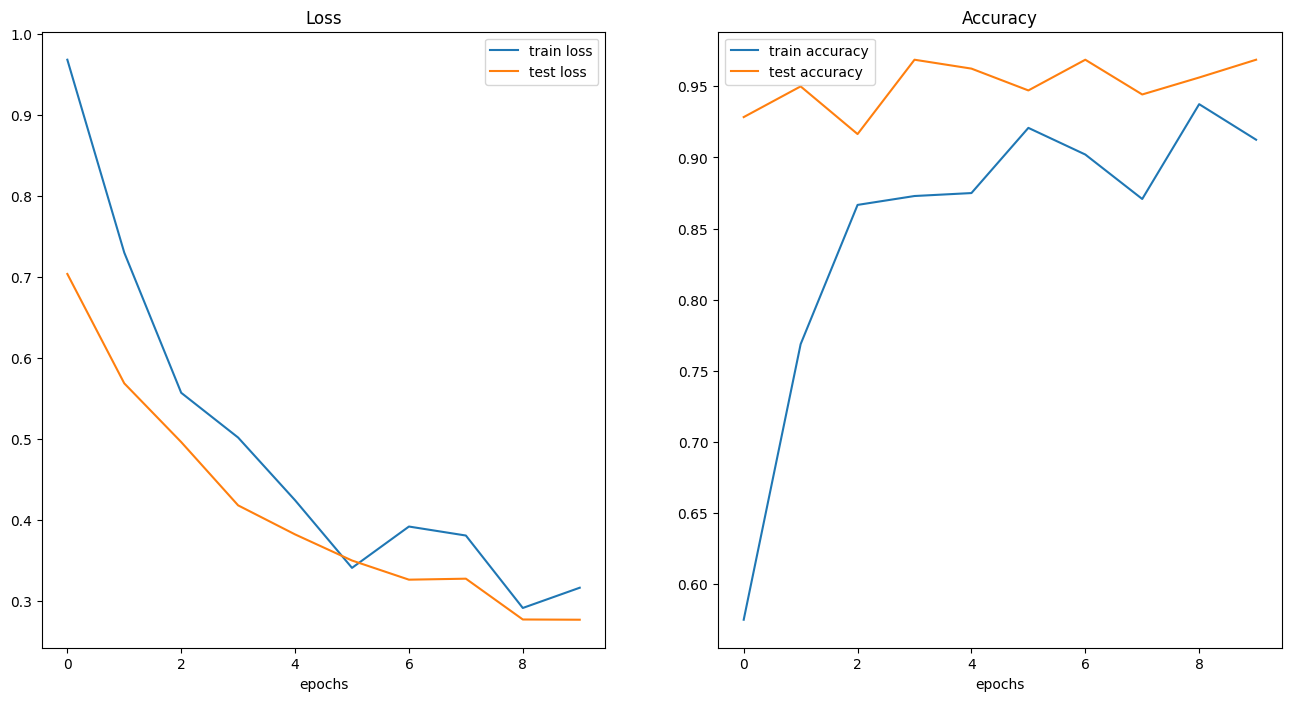

In [ ]:
plot_loss_curves(eff_net_b2_results)

Saving Eff_Net_B2 Feature Extractor

In [ ]:
import utils
utils.save_model(model=eff_net_b2,
                 target_dir='models',
                 model_name='pretrained_eff_net_b2_feature_extractor.pth')

Saving model to:models/pretrained_eff_net_b2_feature_extractor.pth


Checking Size of Model

In [ ]:
from pathlib import Path
eff_net_b2_size=Path('models/pretrained_eff_net_b2_feature_extractor.pth').stat().st_size//(1024*1024)#division converts bytes to MBs
print(f"The Pretrained EfficientNet_B2 feature extractor has size: {eff_net_b2_size} MB")

The Pretrained EfficientNet_B2 feature extractor has size: 29 MB


Counting number of parameters

In [ ]:
num_parameters=sum(p.numel() for p in eff_net_b2.parameters())

Important Stats of Eff_Net_B2

In [ ]:
eff_net_b2_stats={"test loss": eff_net_b2_results['test_loss'][-1],
                  'test accuracy': eff_net_b2_results['test_acc'][-1],
                  'Number of parameters':num_parameters,
                  'Model Size(MB)': eff_net_b2_size}

eff_net_b2_stats

{'test loss': 0.27627702951431277,
 'test accuracy': 0.96875,
 'Number of parameters': 7705221,
 'Model Size(MB)': 29}

##Getting ViT model

In [ ]:
def create_vit_b_16(num_classes:int=3):
  #1
  weights=torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.vit_b_16(weights=weights).to(device)

  #2. freeze all parameters in feature extraction layer
  for param in model.features.parameters():
    param.requires_grad=False
  #3. set random seed
  set_seeds()

  #4. changing classifier layer
  model.heads= torch.nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                        nn.Linear(in_features=1408,
                                                  out_features=num_classes,
                                                  bias=True).to(device))
  #5. give name
  model.name='vit_b_16'
  print(f"Making Vision_Transformer_B16")

  return model,weights,transforms

In [ ]:
vit_b16,vit_b16_weights,vit_b16_transforms=create_vit_b_16(num_classes=3)

In [ ]:
from torchinfo import summary
summary(vit_b16,input_size=(32,3,224,224),col_names=['input_size','output_size','num_params','trainable'], row_settings=['var_names'])

Create dataloaders

In [ ]:
import data_setup
train_dataloader_vit_b16, test_dataloader_vit_b16, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              train_transform=vit_b16_transforms,
                                                                              test_transform=vit_b16_transforms,
                                                                              batch=32)

Training ViT feature extractor

In [ ]:
import engine
#set optimizer
optimizer=torch.optim.Adam(params=vit_b16.parameters(),lr=0.001)

#set loss function
loss_fn=torch.nn.CrossEntropyLoss()

#train
vit_b16_results=engine.train(model=vit_b16,
                             train_dataloader=train_dataloader_vit_b16,
                             test_dataloader=test_dataloader_vit_b16,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=10,
                             device=device)

Plot loss curves

In [ ]:
plot_loss_curves(vit_b16_results)

Saving ViT Feature Extractor

In [ ]:
import utils
utils.save_model(model=vit_b16,
                 target_dir='models',
                 model_name='pretrained_vit_b16_feature_extractor.pth')

Counting Number of Parameters

In [ ]:
num_parameters_vit=sum(p.numel() for p in vit_b16.parameters())

Checking Size of ViT_B16

In [ ]:
from pathlib import Path
vit_b16_size=Path('models/pretrained_vit_b16_feature_extractor.pth').stat().st_size//(1024*1024)#division converts bytes to MBs

Important Stats of ViT_B16

In [ ]:
vit_b16_stats={"test loss": vit_b16_results['test_loss'][-1],
                  'test accuracy': vit_b16_results['test_acc'][-1],
                  'Number of parameters':num_parameters_vit,
                  'Model Size(MB)': vit_b16_size}

vit_b16_stats